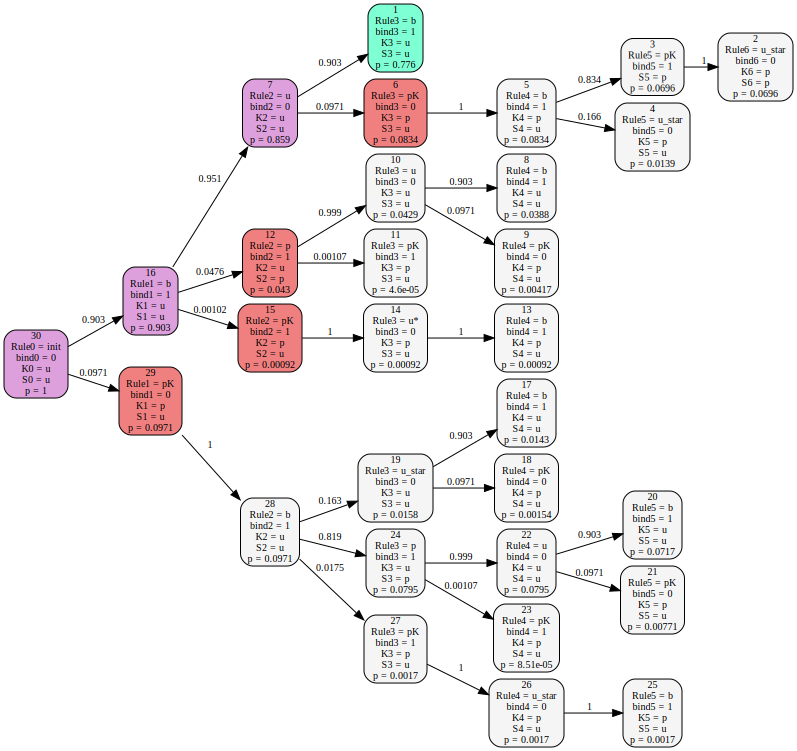

In [41]:
# Creata a blank probability tree.
from probability_trees import MinCut, Critical, PTree

pt = PTree()
b = 0.0093
u = 0.9337
u_star = 0.0093
p = 0.0467
pK = 0.001
# Add a root node and the children.
pt.root('Rule0=init, bind0=0, K0=u, S0=u', [
    pt.child(b/(b+pK), 'Rule1=b, bind1=1, K1=u, S1=u',[
        pt.child(u/(u+p+pK),   'Rule2=u, bind2=0, K2=u ,S2=u',[
            pt.child(b/(b+pK),    'Rule3=b, bind3=1, K3=u ,S3=u'),
            pt.child(pK/(b+pK),   'Rule3=pK, bind3=0, K3=p, S3=u',[
                pt.child(b/b,       'Rule4=b, bind4=1, K4=p, S4=u',[
                    pt.child(p/(p+u_star),      'Rule5=pK, bind5=1, S5=p',[
                        pt.child(u_star/u_star,      'Rule6=u_star, bind6=0, K6=p, S6=p')
                    ]),
                    pt.child(u_star/(p+u_star), 'Rule5=u_star, bind5=0, K5=p, S5=u')
                ])
            ])  
        ]),
        pt.child(p/(u+p+pK),    'Rule2=p, bind2=1, K2=u, S2=p',[
            pt.child(u/(u+pK),     'Rule3=u, bind3=0, K3=u, S3=u',[
                pt.child(b/(b+pK),    'Rule4=b, bind4=1, K4=u, S4=u'),
                pt.child(pK/(b+pK),   'Rule4=pK, bind4=0, K4=p ,S4=u')
            ]),
            pt.child(pK/(u+pK),    'Rule3=pK, bind3=1, K3=p, S3=u')
        ]),
        pt.child(pK/(u+p+pK),   'Rule2=pK, bind2=1, K2=p, S2=u',[
            pt.child(u_star/u_star, 'Rule3=u*, bind3=0, K3=p, S3=u',[
                pt.child(b/b,          'Rule4=b, bind4=1, K4=p, S4=u')
            ]),
        ])
    ]),
    pt.child(pK/(b+pK), 'Rule1=pK, bind1=0, K1=p, S1=u',[
        pt.child(b/b,      'Rule2=b , bind2=1, K2=u, S2=u',[
            pt.child(u_star/(u_star + p + pK), 'Rule3=u_star, bind3=0, K3=u, S3=u',[
                pt.child(b/(b+pK),                'Rule4=b, bind4=1, K4=u, S4=u'),
                pt.child(pK/(b+pK),               'Rule4=pK, bind4=0, K4=p, S4=u')
            ]),
            pt.child(p/(u_star + p + pK),      'Rule3=p, bind3=1, K3=u, S3=p',[
                pt.child(u/(u+pK),               'Rule4=u, bind4=0, K4=u, S4=u',[
                    pt.child(b/(b+pK),               'Rule5=b, bind5=1, K5=u, S5=u'),
                    pt.child(pK/(b+pK),              'Rule5=pK, bind5=0, K5=p, S5=u')
                ]),
                pt.child(pK/(u+pK),              'Rule4=pK, bind4=1, K4=p, S4=u')
            ]),
            pt.child(pK/(u_star + p + pK),     'Rule3=pK , bind3=1, K3=p, S3=u',[
                pt.child(u_star/u_star,            'Rule4=u_star, bind4=0, K4=p, S4=u',[
                    pt.child(b/b,                     'Rule5=b, bind5=1, K5=p, S5=u')
                ]),
            ])
        ])
     ])
])



# Display it.
display(pt.show(show_prob=True,
            cut=pt.prop('Rule3=b'),
                crit=pt.critical(pt.prop('Rule3=b')),
                show_id=True
               ))

In [68]:
def KappaModel( bvars, b = 0.0093,
                      u = 0.9337,
                      u_star = 0.0093,
                      p = 0.0467,
                      pK = 0.001, 
                      tmax=6,
                      semantics='trace'):
    
    t=0
    if 'Rule0' not in bvars:
        return init( t )
    while f'Rule{t}' in bvars:
        t += 1
    if t <= tmax:
        #print(t)
        if semantics=='trace':
            return apply_selected_rules( bvars, t, b, u, u_star, p , pK )
        else:
            return apply_all_rules( bvars, t, b, u, u_star, p , pK )
    else:
        return None   

def init( t):
    return f'Rule{t}=init, bind{t}=0, S{t}=u, K{t}=u'

def apply_all_rules( bvar, t, b, u, u_star, p, pK ):
    bind_prob, bind_state = binding( bvar, b, t )
    u_prob, u_state = fast_unbinding(bvar, u, t )
    u_star_prob, u_star_state = slow_unbinding( bvar, u_star, t )
    p_prob, p_state = substrate_phosphorylation( bvar, p, t)
    pK_prob, pK_state = kinase_phosphorylation( bvar, pK, t)
    total_prob = bind_prob + u_prob + u_star_prob + p_prob + pK_prob
    return [(bind_prob/total_prob, bind_state),
            (u_prob/total_prob, u_state),
            (u_star_prob/total_prob, u_star_state),
            (p_prob/total_prob, p_state),
            (pK_prob/total_prob, pK_state)
           ]

def apply_selected_rules( bvar, t, b, u, u_star, p, pK ):
    prob_state = []
    prob_state.append( binding( bvar, b, t ) )
    prob_state.append(fast_unbinding(bvar, u, t ) )
    prob_state.append( slow_unbinding( bvar, u_star, t ) )
    prob_state.append(substrate_phosphorylation( bvar, p, t))
    prob_state.append( kinase_phosphorylation( bvar, pK, t))
    total_prob = sum([prob for prob, state in prob_state])
    return [(prob/total_prob, state) 
            for prob, state in prob_state
            if prob > 0
           ]


def binding( bvar, b, t ):
    bind, S, K = bvar[f'bind{t-1}'], bvar[f'S{t-1}'], bvar[f'K{t-1}']
    if bind == '0':
        return b, f'Rule{t}=b, bind{t}=1, S{t}={S}, K{t}={K}'
    else:
        return 0, f'Rule{t}=b, bind{t}={bind}, S{t}={S}, K{t}={K}'

def fast_unbinding( bvar, u, t):
    bind, S, K = bvar[f'bind{t-1}'], bvar[f'S{t-1}'], bvar[f'K{t-1}']
    if bind == '1' and K == 'u':
        return u, f'Rule{t}=u, bind{t}=0, S{t}={S}, K{t}={K}'
    else:
        return 0, f'Rule{t}=u, bind{t}={bind}, S{t}={S}, K{t}={K}'
    
def slow_unbinding( bvar, u_star, t):
    bind, S, K = bvar[f'bind{t-1}'], bvar[f'S{t-1}'], bvar[f'K{t-1}']
    if bind == '1' and K == 'p':
        return u_star, f'Rule{t}=u_star, bind{t}=0, S{t}={S}, K{t}={K}'
    else:
        return 0, f'Rule{t}=u_star, bind{t}={bind}, S{t}={S}, K{t}={K}'

def substrate_phosphorylation( bvar, p, t ):
    bind, S, K = bvar[f'bind{t-1}'], bvar[f'S{t-1}'], bvar[f'K{t-1}']
    if bind == '1' and S == 'u':
        return p, f'Rule{t}=p, bind{t}={bind}, S{t}=p, K{t}={K}'
    else:
        return 0, f'Rule{t}=p, bind{t}={bind}, S{t}={S}, K{t}={K}'
    
def kinase_phosphorylation( bvar, pK, t ):
    bind, S, K = bvar[f'bind{t-1}'], bvar[f'S{t-1}'], bvar[f'K{t-1}']
    if K == 'u':
        return pK, f'Rule{t}=pK, bind{t}={bind}, S{t}=p, K{t}=p'
    else:
        return 0, f'Rule{t}=pK, bind{t}={bind}, S{t}={S}, K{t}={K}'
        
    

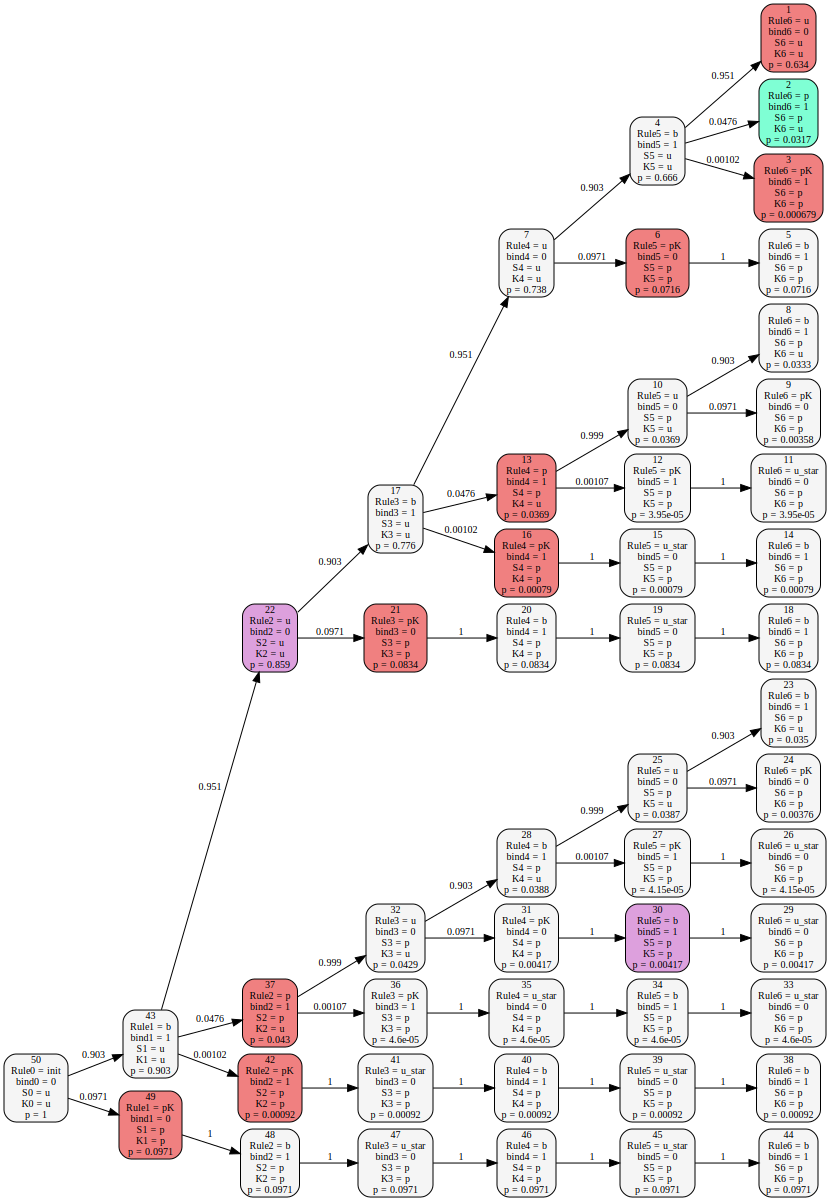

In [70]:
kappa = PTree.fromFunc(KappaModel, init( 0 ))
display(kappa.show(show_prob=True,
            cut=kappa.prop('Rule6=p'),
                crit=pt.critical(kappa.prop('Rule6=p')),
                show_id=True
               ))

In [53]:
init(0)

[(1, 'Rule0=init, bind0=0, S0=u, K0=u')]